<a href="https://colab.research.google.com/github/yamuzin-oksusu/UCI_DAB/blob/main/Project/Project_fullcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
PATH = "/content/drive/MyDrive/UCI_DAB/project/"

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [7]:
data_application = pd.read_csv(PATH+"application_record.csv")
data_credit = pd.read_csv(PATH+"credit_record.csv")


## Data Preprocessing (Target Variable)

In [8]:
# find all users' account open month.
begin_month=pd.DataFrame(data_credit.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data_application,begin_month,how="left",on="ID") #merge to data_credit data

In [9]:
data_credit['dep_value'] = None
data_credit['dep_value'][data_credit['STATUS'] =='1']='Yes' 
data_credit['dep_value'][data_credit['STATUS'] =='2']='Yes' 
data_credit['dep_value'][data_credit['STATUS'] =='3']='Yes' 
data_credit['dep_value'][data_credit['STATUS'] =='4']='Yes' 
data_credit['dep_value'][data_credit['STATUS'] =='5']='Yes'


In [10]:
cpunt=data_credit.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 1]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 1]='No' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1 
new_data.loc[new_data['target']=='No','target']=0

In [11]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     43401
Yes     2584
Name: dep_value, dtype: int64


No     0.943808
Yes    0.056192
Name: dep_value, dtype: float64

In [12]:
new_data.tail()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month,dep_value,target
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,-2420,1,0,0,0,Managers,2.0,-11.0,Yes,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-23.0,Yes,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,-1325,1,0,1,1,Medicine staff,2.0,-32.0,Yes,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,-655,1,0,0,0,Sales staff,2.0,-9.0,Yes,1
36456,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,...,-1193,1,0,0,0,Laborers,1.0,-13.0,Yes,1


In [13]:
new_data.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,begin_month
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


## Data Preprocessing (Features)

In [14]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()

using 5 columns 
- **FLAG_OWN_REALTY**: Reality
- **CNT_FAM_MEMBERS**: famsize
- **FLAG_OWN_CAR**: Car
- **AMT_INCOME_TOTAL**: inc
- **OCCUPATION_TYPE**: occyp

In [15]:
new_data.rename(columns={'FLAG_OWN_REALTY':'Reality','CNT_FAM_MEMBERS':'famsize',
                         'FLAG_OWN_CAR':'Car','AMT_INCOME_TOTAL':'inc','OCCUPATION_TYPE':'occyp'
                         },inplace=True)

### Binary features
- Car
- Reality

In [16]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])


In [17]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])


In [18]:
new_data=new_data[["ID","Car","Reality","famsize","inc","occyp","begin_month","target"]]

In [19]:
new_data.head()

,ID,Car,Reality,famsize,inc,occyp,begin_month,target
2,5008806,1,1,2.0,112500.0,Security staff,-29.0,0
3,5008808,0,1,1.0,270000.0,Sales staff,-4.0,0
4,5008809,0,1,1.0,270000.0,Sales staff,-26.0,0
5,5008810,0,1,1.0,270000.0,Sales staff,-26.0,0
6,5008811,0,1,1.0,270000.0,Sales staff,-38.0,0


### continuous features
- famsize
- inc

In [20]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
new_data.head()

,ID,Car,Reality,famsize,inc,occyp,begin_month,target,famsizegp
2,5008806,1,1,2,112500.0,Security staff,-29.0,0,2
3,5008808,0,1,1,270000.0,Sales staff,-4.0,0,1
4,5008809,0,1,1,270000.0,Sales staff,-26.0,0,1
5,5008810,0,1,1,270000.0,Sales staff,-26.0,0,1
6,5008811,0,1,1,270000.0,Sales staff,-38.0,0,1


In [21]:
new_data["famsizegp"].unique()

array([2, 1, '3more'], dtype=object)

In [26]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [27]:
new_data = convert_dummy(new_data,'famsizegp')

In [28]:
new_data.head()

,ID,Car,Reality,famsize,inc,occyp,begin_month,target,famsizegp_1,famsizegp_3more
2,5008806,1,1,2,11.25,Security staff,-29.0,0,0,0
3,5008808,0,1,1,27.0,Sales staff,-4.0,0,1,0
4,5008809,0,1,1,27.0,Sales staff,-26.0,0,1,0
5,5008810,0,1,1,27.0,Sales staff,-26.0,0,1,0
6,5008811,0,1,1,27.0,Sales staff,-38.0,0,1,0


(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


<Axes: ylabel='Frequency'>

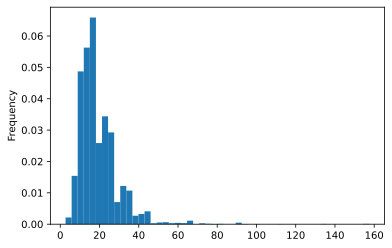

In [22]:
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [35]:
new_data['inc'].info

<bound method Series.info of 2        11.25
3         27.0
4         27.0
5         27.0
6         27.0
         ...  
36452     31.5
36453    15.75
36454    15.75
36455    28.35
36456    11.25
Name: inc, Length: 25134, dtype: object>

In [36]:
new_data = new_data.astype({'inc':'float64'})

In [24]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [37]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
new_data.head()

,ID,Car,Reality,famsize,inc,occyp,begin_month,target,famsizegp_1,famsizegp_3more,gp_inc
2,5008806,1,1,2,11.25,Security staff,-29.0,0,0,0,low
3,5008808,0,1,1,27.00,Sales staff,-4.0,0,1,0,high
4,5008809,0,1,1,27.00,Sales staff,-26.0,0,1,0,high
5,5008810,0,1,1,27.00,Sales staff,-26.0,0,1,0,high
6,5008811,0,1,1,27.00,Sales staff,-38.0,0,1,0,high


In [38]:
new_data = convert_dummy(new_data,'gp_inc')

### categorical feature
- occupy

In [39]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


In [40]:
new_data = convert_dummy(new_data,'occyp')

In [42]:
new_data.head()

,ID,Car,Reality,famsize,inc,begin_month,target,famsizegp_1,famsizegp_3more,gp_inc_high,gp_inc_medium,occyp_hightecwk,occyp_officewk
2,5008806,1,1,2,11.25,-29.0,0,0,0,0,0,0,0
3,5008808,0,1,1,27.00,-4.0,0,1,0,1,0,0,1
4,5008809,0,1,1,27.00,-26.0,0,1,0,1,0,0,1
5,5008810,0,1,1,27.00,-26.0,0,1,0,1,0,0,1
6,5008811,0,1,1,27.00,-38.0,0,1,0,1,0,0,1


## Modeling

split the dataset

In [41]:
new_data.columns

Index(['ID', 'Car', 'Reality', 'famsize', 'inc', 'begin_month', 'target',
       'famsizegp_1', 'famsizegp_3more', 'gp_inc_high', 'gp_inc_medium',
       'occyp_hightecwk', 'occyp_officewk'],
      dtype='object')

In [43]:
Y = new_data['target']
X = new_data[['Car','Reality',
              'famsizegp_1', 'famsizegp_3more',
              'gp_inc_high', 'gp_inc_medium',
              'occyp_hightecwk', 'occyp_officewk']]

Using Synthetic Minority Over-Sampling Technique(SMOTE) to overcome sample imbalance problem.

In [45]:
from imblearn.over_sampling import SMOTE
import itertools

In [47]:
Y = Y.astype('int')
oversample = SMOTE()
X_balance,Y_balance = oversample.fit_resample(X, Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

After over sampling, the number between 1 and 0 is balanced. It can be seen from the confusion matrix.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10000)

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy Score is 0.53253
      0     1
0  3958  3121
1  3497  3581
[[0.55911852 0.44088148]
 [0.49406612 0.50593388]]


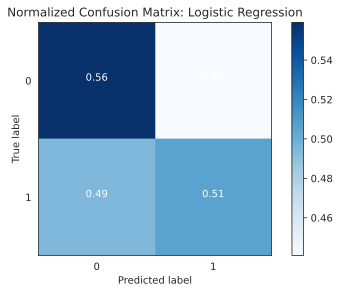

In [51]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

Accuracy score is around 53% 

Accuracy Score is 0.58226
      0     1
0  3573  3506
1  2408  4670
[[0.50473231 0.49526769]
 [0.3402091  0.6597909 ]]


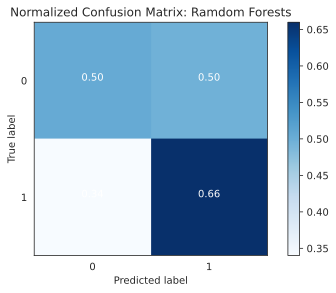

In [52]:
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')